In [17]:
%matplotlib inline
import sys, os, glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as pth

from dask.distributed import Client
os.chdir('/g/data/e14/rmh561/croco/analysis/PAC12_75_cpl/')

In [18]:
import quadrilateral_tools as intp 

In [19]:
def lonlat_to_m(lon,lat,plon,plat):
    # follow Haversine formula
    lon  = lon*2.*np.pi/360.
    lat  = lat*2.*np.pi/360.
    plon = plon*2*np.pi/360.
    plat = plat*2*np.pi/360
    if isinstance(lon,float):
        dx = np.arccos(np.sin(lat)*np.sin(plat) + np.cos(lat)*np.cos(plat)*np.cos(lon-plon))*6371000.
    else:
        dx = np.arccos(np.sin(lat[:])*np.sin(plat) + np.cos(lat[:])*np.cos(plat)*np.cos(lon[:]-plon))*6371000.
    return dx

In [20]:
##### Input files #########

iodir = '/g/data/e14/rmh561/croco/data/OASIS_FILES/PAC12_75_cpl/' # Input repository

## OCE ##
fileo = iodir+'croco_grd.nc' # Ocean grid file

## ATM ##e
filea = iodir+'wrf_grd.nc' # Atmosphere grid file
filemask= iodir +'wrf_grd.nc' # where to find CPLMASK
extdom = 0  # which external domain should we select in CPLMASK

### Do you want to perform test? (plot without smoothing/save netcdf sst smoothed)
test_flag=1
sstfile=iodir+'sst.nc' # sst file (var need to be temp)

# pixels at a distance of more than 3sig are small enough to be
# considered effectively zero
sigx = 24
sigy = 1
cutratio = 0.01

## Output file ##
foldout=iodir # where OASIS_FILES should be
fileout = 'mapping_o2a_gauss_sigx'+'{:02d}'.format(int(sigx))+'_sigy'+'{:02d}'.format(int(sigy))+'_cut'+'{:02d}'.format(int(cutratio*100))+'.nc'

# Load data

In [21]:
# croco grid  

ncf=nc.Dataset(fileo,'r')
lono = ncf.variables['lon_rho'][1:-1,1:-1]
lato = ncf.variables['lat_rho'][1:-1,1:-1]
msko = ncf.variables['mask_rho'][1:-1,1:-1]
ncf.close()

[jpio,jpjo]=np.shape(lono)
jpijo = jpio * jpjo

# wrf grid

ncf=nc.Dataset(filea,'r')
lona = np.squeeze(ncf.variables['XLONG'][:])
lata = np.squeeze(ncf.variables['XLAT'][:])
ncf.close

ncf=nc.Dataset(filemask,'r')
mska = np.squeeze(ncf.variables['CPLMASK'][0,extdom,:,:])
ncf.close()

[jpia,jpja]=np.shape(lona)

# extend theta domain...
# longitude
dx = lona[-1,:] - lona[-2,:]
lona = np.row_stack((lona,lona[-1,:]+dx))
lona = np.c_[lona,lona[:,-1]]

# latitude
lata = np.row_stack((lata, lata[-1,:]))
dy = lata[:,-1]-lata[:,-2]
lata = np.c_[lata,lata[:,-1]+dy]

[jpia,jpja]=np.shape(lona)
jpija = jpia * jpja

# mask
mska = np.c_[mska,np.zeros(jpia-1)]
mska = np.row_stack(( mska,np.zeros(jpja) ))

# Build bi-linear interpolation weights

In [ ]:

weio2a = np.zeros([jpija, 4])
addo2a = np.zeros([jpija, 4])

#
# define all cells that have corners located at lono, lato
# we define the cell with the address of all corners
#
#            3  bdy2 2
#             +------+
#             |      |
#         bdy3|      |bdy1
#             |      |
#             +------+
#            0  bdy0 1
#
celladdr0 = np.arange(0,jpijo).reshape(jpio,jpjo)
# remove last line/colomn  
celladdr0 = celladdr0[0:-1,0:-1].ravel()

xx0 = lono.ravel()[celladdr0]
yy0 = lato.ravel()[celladdr0]
celladdr1 = celladdr0 + 1
xx1 = lono.ravel()[celladdr1]
yy1 = lato.ravel()[celladdr1]
celladdr2 = celladdr1 + jpjo
xx2 = lono.ravel()[celladdr2]
yy2 = lato.ravel()[celladdr2]
celladdr3 = celladdr2 - 1
xx3 = lono.ravel()[celladdr3]
yy3 = lato.ravel()[celladdr3]

print('Begin creating weight')

perc=0
for ii in range(0,jpija):
    if (100*ii/jpija >= perc ): print("%02d%% done..." % perc );perc+=10
    xx = lona.ravel()[ii]
    yy = lata.ravel()[ii]
# Find for closest points
#        dist=lonlat_to_m(xx0,yy0,xx,yy).ravel()
    dist=np.sqrt((xx-xx0)**2+(yy-yy0)**2)      
    for jj in range(0,8): # loop on 4 closest points
        distok=np.argmin(dist).astype('int')
        dist[distok]=1e9 # put high number instead of NAN as argmin is faster ( about 3 times) than nanargmin

        xx0ok = xx0[distok]
        yy0ok = yy0[distok]
        xx1ok = xx1[distok]
        yy1ok = yy1[distok]
        xx2ok = xx2[distok]  
        yy2ok = yy2[distok]
        xx3ok = xx3[distok]
        yy3ok = yy3[distok]

# Check if point is in quad
        polygon=np.array((np.hstack((xx0ok,xx1ok,xx2ok,xx3ok,xx0ok)),np.hstack((yy0ok,yy1ok,yy2ok,yy3ok,yy0ok)) )).T
        points = np.array(( xx.ravel(),yy.ravel() )).T

        isin = pth.Path(polygon,closed=True).contains_points(points) 
        if isin : 
            ind=distok
#   
            xtmp0=np.array([xx0ok]); ytmp0=np.array([yy0ok])
            xtmp1=np.array([xx1ok]); ytmp1=np.array([yy1ok])
            xtmp2=np.array([xx2ok]); ytmp2=np.array([yy2ok])
            xtmp3=np.array([xx3ok]); ytmp3=np.array([yy3ok])
            xtmp =np.array([xx])   ; ytmp =np.array([yy])

            xy=intp.quadrilateral2square(xtmp0,ytmp0,xtmp1,ytmp1,xtmp2,ytmp2,xtmp3,ytmp3,xtmp,ytmp)
            xy = np.round(1000.*xy)/1000.

# define 4 interpolating corners address (with sorted address: 0,1,3,2)
            addtmp = celladdr0[ind] 
            addo2a[ii, 0] = addtmp
            addo2a[ii, 1] = addtmp+1
            addo2a[ii, 2] = addtmp+jpjo
            addo2a[ii, 3] = addtmp+1+jpjo

# define 4 interpolating corners weight
            weio2a[ii, 0] = (1. - xy[0]) * (1. - xy[1])
            weio2a[ii, 1] =       xy[0]  * (1. - xy[1])
            weio2a[ii, 2] = (1. - xy[0]) *       xy[1]
            weio2a[ii, 3] =       xy[0]  *       xy[1]
            break
print('End building weight inside oce grid')

###########################################################

print('Building weight outside oce grid')

totwei = np.sum(weio2a, 1) #sum over column
bad = np.argwhere(totwei.ravel()==0); nbad=len(bad) # check where 0

del dist, distok
if nbad != 0:
    perc=0
    for ii in range(0,nbad):
        if (100*ii/nbad > perc ): print("%02d%% done..." % perc );perc+=10

        xx = lona.ravel()[int(bad[ii])]
        yy = lata.ravel()[int(bad[ii])]

   # Find 4 closest ocean points 
        distok=np.empty(4)
        distfin=np.empty(4)
#            dist=lonlat_to_m(lono.ravel(),lato.ravel(),xx,yy)
        dist=np.sqrt((xx-lono.ravel())**2+(yy-lato.ravel())**2)
        for kk in range(0,distok.shape[0]):
            distok[kk] = np.argmin(dist).astype('int')
            distfin[kk]=dist[distok[kk].astype('int')]
            dist[distok[kk].astype('int')]=1e5

        addo2a[bad[ii], :] = np.sort(distok)
        weio2a[bad[ii], :] = 1./np.sqrt(distfin[np.argsort(distok)])
        weio2a[bad[ii], :] = np.round(1000.*weio2a[bad[ii], :])/1000.

print('End building weight outside oce grid')

# normalize weio2a
totweir = 1./np.sum(weio2a,1)
weio2a = weio2a * np.outer(totweir,np.ones(4) )

del dist,distfin,distok,bad,xx0,yy0,xx1,yy1,xx2,yy2,xx3,yy3

# Smooth atmosphere values

In [22]:
# compute weights and addresses for the smooth of atm grid
#   --> addasmth and weiasmth  (jpija, nn*nn)

# pixels at a distance of more than 3sig are small enough to be
# considered effectively zero

nn = int(3*2*sigx+1)
nn2 = nn*nn

# gaussian window
xx = np.outer(np.arange(0,nn),np.ones(nn))             # (nn, nn) 
yy = np.outer(np.ones(nn) ,np.arange(0,nn))            # (nn, nn)
dd = np.sqrt( ((xx-nn/2)**2)/sigx**2 + ((yy-nn/2)**2)/sigy**2 )
ww = 1./(2*np.pi*sigx*sigy) *np.exp( -0.5*dd**2 )   # (nn, nn) 
#keepww = np.argwhere((ww.ravel() >= max(ww.ravel())*cutratio)); nnok=len(keepww)
#ww = ww.ravel()[keepww]                                # (nnok)

#winaddx = np.outer(np.ones(nn),np.arange(0,nn)-nn/2)   # (nn, nn)
#winaddy = np.outer(np.arange(nn)-nn/2,np.ones(nn))     # (nn, nn)
#winaddx = winaddx.ravel()[keepww.astype('int')]        # (nnok)
#winaddy = winaddy.ravel()[keepww.astype('int')]        # (nnok)

In [23]:
np.shape(ww)

(145, 145)

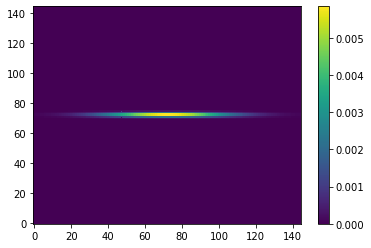

In [25]:
cmap = plt.pcolor(xx,yy,ww)
plt.colorbar(cmap)

(62.0, 82.0)

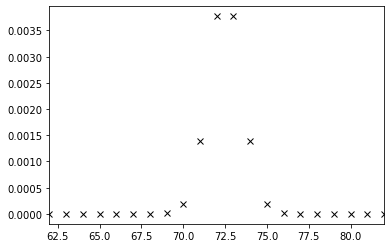

In [30]:
plt.plot(yy[50,:],ww[50,:],'xk')
plt.xlim([62,82])